<a href="https://colab.research.google.com/github/Norberto27/Norberto_ProcDelHabla/blob/main/NRMU_T1_Deteccion_Anomalias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. TÍTULO Y DATOS**

#**Título: Detección de Anomalías con Embeddings - Martín Fierro y Fausto**

**Opcion 2**

#**2. Autor**

##**Desarrollador: Norberto Raul Martearena Urquiza**

##**Legajo: 11099**

##**Fecha: 20/12/2024**


#**3. Instalación de Librerías**

**Librerías Instaladas y sus Funciones**

Mas alla de las librerias de las librerias que se puedan utilizar mas adelante, detallo las que usare para este desarrollo:

**sentence-transformers**

Me permite trabajar con modelos preentrenados de embeddings para texto.
Se usa para convertir textos (oraciones, párrafos, etc.) en vectores numéricos que representan su significado. Fundamental para medir similitudes entre textos usando distancias como coseno.

**PyPDF2**

Esta librería para la  manipulacion de archivos PDF. Permitiendo leer, extraer texto, combinar y dividir archivos PDF.

**matplotlib**

Librería para la visualización de datos. La utilizo para crear gráficos como histogramas, curvas de similitud, etc.
Permite tener una mejor visualizacion para analizar los resultados de la detección de anomalías.

**pdfplumber**

Es una herramienta especializada en extraer texto de archivos PDF de forma más precisa que PyPDF2, especialmente cuando los PDFs tienen tablas o texto formateados.
Complementa o reemplaza a PyPDF2 en situaciones donde la extracción del texto es compleja.

**scikit-learn**

Librería clave para aprendizaje automático y análisis de datos.
Ofrece funciones para dividir datasets, calcular distancias (coseno, euclidiana, etc.), y evaluar modelos de machine learning.
Se usará para la detección de anomalías y el cálculo de medidas de similitud.

nltk (Natural Language Toolkit)

Conjunto de herramientas para procesamiento del lenguaje natural.
Permite realizar tareas como tokenización, eliminación de stop words, y otras técnicas de limpieza y análisis de texto.
Importante para el preprocesamiento de los textos de Martín Fierro y Fausto.


In [ ]:
# Procederé a instalar las librerías necesarias para este notebook
!pip install sentence-transformers PyPDF2 matplotlib
!pip install pdfplumber
!pip install scikit-learn
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 46.8 MB/s eta 0:00:00


#**4. Introducción**

La detección de anomalías es un proceso que identifica datos que no encajan con un conjunto "normal".

En este notebook, voy a trabajar con el **Martín Fierro** (texto base) y comparar su estilo con el del **Fausto**, otro libro de poesía gauchesca.

El objetivo es identificar si los textos del Fausto pueden ser detectados como "anómalos" al compararlos con el Martín Fierro, utilizando embeddings de texto y medidas de distancia.


#**5. Carga y Preprocesamiento de Datos**

In [ ]:
# Importar librerías necesarias
from PyPDF2 import PdfReader
import re
import requests

# Función para limpiar y dividir en estrofas
def limpiar_y_dividir_en_estrofas(texto):
    inicio_poema = "Aquí me pongo a cantar"
    if inicio_poema in texto:
        texto = texto.split(inicio_poema, 1)[1]
        texto = inicio_poema + texto  # Asegurar que comienza correctamente

    texto = re.sub(r'Recursos de dominio público.*?Página \d+', '', texto, flags=re.DOTALL)
    texto = re.sub(r'El gaucho Martín Fierro', '', texto, flags=re.IGNORECASE)
    texto = re.sub(r'José Hernández', '', texto, flags=re.IGNORECASE)
    texto = re.sub(r'Imágenes de dominio público.*', '', texto, flags=re.DOTALL)
    texto = re.sub(r'\b(I|II|III|IV|V|VI|VII|VIII|IX|X|XI|XII|XIII)\b', '', texto)
    texto = re.sub(r'\b(página|Página)\b.*?\d+', '', texto)
    texto = re.sub(r'\n+', '\n', texto).strip()

    lineas = [linea.strip() for linea in texto.split("\n") if linea.strip()]

    estrofas = []
    estrofa = []

    for linea in lineas:
        estrofa.append(linea)
        if len(estrofa) == 6:
            estrofas.append("\n".join(estrofa))
            estrofa = []

    if estrofa:
        estrofas.append("\n".join(estrofa))

    return estrofas

# Descargar el poema
url = "https://www.argentina.gob.ar/sites/default/files/hernandez_jose_-_el_gaucho_martin_fierro.pdf"
response = requests.get(url)

# Guardar el PDF
with open("martin_fierro.pdf", "wb") as f:
    f.write(response.content)

# Leer y procesar el texto
reader_mf = PdfReader("martin_fierro.pdf")
texto_mf = " ".join([page.extract_text() for page in reader_mf.pages])
estrofas_mf = limpiar_y_dividir_en_estrofas(texto_mf)

# Calcular longitud promedio de fragmentos
longitudes_mf = [len(estrofa.split()) for estrofa in estrofas_mf]
longitud_promedio = int(sum(longitudes_mf) / len(longitudes_mf))
print(f"Longitud promedio de fragmentos (Martín Fierro): {longitud_promedio} palabras")

# Dividir en fragmentos uniformes
def dividir_en_fragmentos(texto, tamaño_fragmento):
    palabras = texto.split()
    return [
        " ".join(palabras[i:i + tamaño_fragmento])
        for i in range(0, len(palabras), tamaño_fragmento)
    ]

fragmentos_mf = dividir_en_fragmentos(" ".join(estrofas_mf), longitud_promedio)
print("Primeros fragmentos del Martín Fierro:")
for i, fragmento in enumerate(fragmentos_mf[:3]):
    print(f"\nFragmento {i+1}:\n{fragmento}")





Longitud promedio de fragmentos (Martín Fierro): 29 palabras
Primeros fragmentos del Martín Fierro:

Fragmento 1:
Aquí me pongo a cantar al compás de la vigüela, que el hombre que lo desvela una pena estrordinaria, como la ave solitaria con el cantar se consuela. Pido

Fragmento 2:
a los santos del cielo que ayuden mi pensamiento: les pido en este momento que voy a cantar mi historia me refresquen la memoria y aclaren mi entendimiento. Vengan

Fragmento 3:
santos milagrosos, vengan todos en mi ayuda, que la lengua se me añuda y se me turba la vista; pido a mi Dios que me asista en una ocasión


Ahora voy a cargar el  texto sobre FAUSTO.

Previamente de entre todas las versiones disponibles que detecte en internet selecciones la siguiente
Biblioteca Virtual Miguel de Cervantes
https://www.cervantesvirtual.com/obra/fausto-seguido-de-poesias-…
Fausto : seguido de Poesías completas / Estanislao del Campo
lo descargue a mi computadora y procedi en este bloque a
subirlo al entorno de gogle colab y luego lo cargue en el notebook.


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving faustoPoesiasCompletas.pdf to faustoPoesiasCompletas.pdf


. Usar Google Drive

Una opción más avanzada y conveniente es montar mi Google Drive en Colab para poder acceder a los archivos de forma más fluida.

para montar Google Drive en Colab con el siguiente código:


from google.colab import drive
drive.mount('/content/drive')

Esto me dará acceso a los archivos que tenga en mi Google Drive, lo que incluye la carpeta Downloads si la tengo sincronizada con Google Drive.



Este bloque tiene como objetivo principal cargar, procesar y estructurar el texto del Fausto para integrarlo al análisis comparativo de similitudes con el texto del Martín Fierro. Aquí se detallan los pasos y las decisiones tomadas, con su respectiva justificación.



In [ ]:
# Importar las librerías necesarias
from PyPDF2 import PdfReader
import re

# Ruta al archivo del Fausto
ruta_fausto = "faustoPoesiasCompletas.pdf"

# Leer el archivo PDF
reader_fausto = PdfReader(ruta_fausto)

texto_fausto = " ".join([page.extract_text() for page in reader_fausto.pages[12:]])

# Truncar el texto en el punto final relevante
texto_fausto_truncado = texto_fausto.split("En sanguinarios excesos, Por mal entendido honor")[0]

# Función para limpieza básica del texto
def limpiar_texto_completo(texto):
    texto = re.sub(r"Estanislao.*?López", "", texto, flags=re.IGNORECASE)
    texto = re.sub(r'\b(página|Página)\b.*?\d+', '', texto)
    texto = re.sub(r'\n+', '\n', texto).strip()
    return texto

# Aplicar limpieza
texto_fausto_limpio = limpiar_texto_completo(texto_fausto_truncado)

# Dividir en fragmentos uniformes (mismo tamaño que Martín Fierro)
fragmentos_fausto = dividir_en_fragmentos(texto_fausto_limpio, longitud_promedio)
print("Primeros fragmentos del Fausto:")
for i, fragmento in enumerate(fragmentos_fausto[:3]):
    print(f"\nFragmento {i+1}:\n{fragmento}")



Primeros fragmentos del Fausto:

Fragmento 1:
FAUSTO 43 Paisano Aniceto el Callo, Puede sin cuidao vivir, Que primero han de decir Que la viscacha es caballo, Y que la gramilla es tallo, Y que el

Fragmento 2:
ombú es verdolaga, Y que es sauce la biznaga, Y que son montes los yuyos, Que asigurar que son suyos Los trjstes versos que yo haga. Adiós gaucho payador

Fragmento 3:
Del ejército unitario; Adiós paisano ño Hilario, Adiós projundo cantor, Adiós pingo cociador, Que a tiranos has pateao, Y que hasta a mí me has largao De pronto un


LIBRERIAS UTILIZADAS:

**PyPDF2:**

Es una librería eficiente para extraer texto de archivos PDF, permitiendo procesar documentos literarios en este formato.

**re:**

Es fundamental para realizar tareas de limpieza y manipulación de texto mediante expresiones regulares, eliminando elementos irrelevantes como referencias o numeración de páginas.

Se omiten las primeras 12 páginas del PDF porque, tras una revisión inicial del documento, se identificó que contienen índices, prólogos y contenido irrelevante para el análisis.

El uso de una comprensión de listas permite consolidar el texto de todas las páginas relevantes en una sola cadena de texto. Esto es esencial para garantizar un análisis coherente y continuo.

El truncamiento se realiza en el punto identificado como final relevante del texto, asegurando que el contenido procesado sea representativo y no incluya información adicional fuera de contexto (como apéndices o notas).
Esta decisión se basa en una revisión manual del contenido del Fausto, que estableció este punto como límite adecuado.

lIMPIEZA DEL TEXTO:

Eliminar menciones específicas: Se identificaron nombres como "Estanislao López" que aparecen repetidamente, pero que no aportan valor al análisis textual. Estas menciones son eliminadas para limpiar el texto.
Eliminar numeración de páginas: Las referencias de páginas son irrelevantes para el análisis de similitud y se eliminan con una expresión regular.
Eliminar saltos de línea múltiples: Esto mejora la legibilidad y asegura una estructura uniforme del texto.

División en Fragmentos

La función dividir_en_fragmentos ya fue definida previamente para procesar el Martín Fierro, y aquí se reutiliza para mantener un enfoque uniforme en la longitud de los fragmentos.

Tamaño uniforme: Dividir ambos textos en fragmentos de longitud similar es crucial para garantizar una comparación equitativa en el análisis de similitud.

iNSPECCION DE LOS PRIMEROS FRAGMENTOS

Se muestran los primeros fragmentos como parte del proceso de inspección inicial. Esto permite verificar que la limpieza y la segmentación se realizaron correctamente.

En este caso, los fragmentos revelan un formato estructurado que facilita el análisis posterior.

Los fragmentos presentan un formato adecuado, aunque se detectan algunos errores tipográficos ("trjstes" y "cociad") provenientes del OCR del PDF.
Este texto será vectorizado y analizado junto con el Martín Fierro para evaluar similitudes y detectar posibles anomalías.

Posibles Mejoras

Aplicar una etapa de corrección ortográfica para solucionar errores tipográficos provenientes del OCR.

Revisar si se puede ajustar el tamaño de los fragmentos para mejorar la representatividad y la calidad del análisis de similitud.


#**6. División de Datos**

#**División en Conjuntos de Entrenamiento y Prueba**


**División de Datos***

Dado que he decidido trabajar con el texto completo del Fausto como una única unidad, la división de datos debe alinearse con esta decisión. Aquí se presenta cómo  estructurar este proceso, en particular para preparar los datos para el análisis de anomalías:

**División de Datos para Análisis:**

Se separará el texto en dos subconjuntos principales:
Entrenamiento: Para modelar el comportamiento normal de las características del texto.

Prueba: Para evaluar el modelo y detectar posibles anomalías.
La división se realizará sobre fragmentos consecutivos del texto, asegurando que el contexto global no se pierda.


In [ ]:
from sklearn.model_selection import train_test_split

# División del Martín Fierro
fragmentos_entrenamiento, fragmentos_prueba_mf = train_test_split(
    fragmentos_mf, test_size=0.2, random_state=42
)

# Agregar los fragmentos del Fausto al conjunto de prueba
fragmentos_prueba = fragmentos_prueba_mf + fragmentos_fausto

print(f"Fragmentos de entrenamiento: {len(fragmentos_entrenamiento)}")
print(f"Fragmentos de prueba: {len(fragmentos_prueba)}")



Fragmentos de entrenamiento: 313
Fragmentos de prueba: 874


Explicación de los Pasos

Fragmentación del Texto Completo:

En esta etapa del proyecto, se llevó a cabo la preparación y división de los datos textuales del Martín Fierro y el Fausto para su uso en el modelo de análisis textual.

El objetivo principal fue estructurar los datos de manera que permitan tanto un entrenamiento efectivo como una evaluación robusta del modelo.

Descripción del Proceso

División del Corpus del Martín Fierro:

Se utilizó el método train_test_split para dividir los fragmentos textuales en dos conjuntos:

**Entrenamiento (80%):** Fragmentos destinados a la construcción del modelo, asegurando que este aprenda patrones relevantes del corpus.

**Prueba (20%):** Fragmentos reservados para evaluar el desempeño del modelo en textos similares, pero no incluidos en el entrenamiento.

La división se realizó con un random_state fijo para garantizar reproducibilidad.

Incorporación del Fausto al Conjunto de Prueba:

Los fragmentos previamente procesados del Fausto se integraron al conjunto de prueba.

Esto permitió evaluar el modelo en un contexto más diverso, incluyendo textos de diferente naturaleza lingüística, temática y estilística.

Estrategia de Evaluación:

La inclusión de textos tanto internos (Martín Fierro) como externos (Fausto) en el conjunto de prueba permite medir:

La capacidad del modelo de generalizar patrones aprendidos.

Su robustez para identificar diferencias contextuales y detectar fragmentos anómalos o "fuera de dominio".

Resultados Preliminares:

Cantidad de Fragmentos:

Conjunto de entrenamiento: Representativo del Martín Fierro (80% de los datos originales).

Conjunto de prueba: Combinación de fragmentos del Martín Fierro (20%) y del Fausto (100%).

Justificación del Enfoque

Eficiencia en el Entrenamiento: La mayoría de los datos del Martín Fierro se destinan al entrenamiento para garantizar que el modelo tenga un corpus amplio y representativo del cual aprender.

Diversidad en la Prueba: La incorporación de un corpus externo (el Fausto) al conjunto de prueba introduce un desafío adicional al modelo, simulando escenarios reales donde este debe analizar textos heterogéneos.

Equilibrio en la Evaluación: Esta estrategia permite medir no solo la precisión del modelo en datos similares, sino también su capacidad para manejar textos distintos, una habilidad crucial en aplicaciones prácticas.

Conclusión

Este proceso asegura una estructura de datos sólida y equilibrada que maximiza la capacidad del modelo para aprender y generalizar, mientras que proporciona una evaluación realista y robusta de su desempeño

#**7: Vectorización del Dataset**

La vectorización es un paso esencial en el procesamiento de textos, ya que convierte datos textuales en una representación numérica que los modelos de aprendizaje automático pueden interpretar. En este caso, se emplea TF-IDF (Term Frequency-Inverse Document Frequency), una técnica ampliamente utilizada para representar texto en un espacio de características numéricas.

Descripción del Proceso
Modelo de Embeddings Utilizado:

Se seleccionó TF-IDF como método de vectorización, configurando el número de características a un máximo de 500 (max_features=500). Esto garantiza que el vector resultante sea manejable y adecuado para el tamaño del dataset.
Entrenamiento del Vectorizador:

El modelo fue entrenado exclusivamente con los fragmentos del conjunto de entrenamiento (Martín Fierro), asegurando que los valores de TF-IDF reflejen las frecuencias relativas dentro de este corpus.
Transformación de los Conjuntos:

Tanto los fragmentos de entrenamiento como los de prueba fueron vectorizados. Esto resulta en dos matrices dispersas, donde cada fila representa un fragmento y cada columna, la relevancia de un término específico.
Justificación del Enfoque TF-IDF
Simplicidad y Eficiencia:

TF-IDF es un modelo simple pero poderoso que calcula la importancia de cada palabra en el contexto del documento y del corpus completo. Este enfoque evita ruido al reducir el peso de palabras comunes y poco informativas.
Adaptación al Tamaño del Dataset:

Para datasets medianos como el actual, TF-IDF es una opción eficiente que no requiere preentrenamiento ni grandes recursos computacionales.
Compatibilidad con la Detección de Anomalías:

La representación vectorial generada por TF-IDF se ajusta bien a métricas de similitud, como la similitud coseno, facilitando la identificación de patrones y detección de fragmentos anómalos

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Entrenar el modelo de embeddings (TF-IDF)
vectorizer = TfidfVectorizer(max_features=500)
vectorizer.fit(fragmentos_entrenamiento)

# Vectorizar ambos conjuntos
X_entrenamiento = vectorizer.transform(fragmentos_entrenamiento)
X_prueba = vectorizer.transform(fragmentos_prueba)


Resultados de la Vectorización
El conjunto de entrenamiento y el conjunto de prueba han sido transformados en matrices numéricas dispersas con un tamaño máximo de 500 características por fragmento.
Estas matrices están listas para ser utilizadas en cálculos de similitud y análisis posteriores.
Comparación con Embeddings Preentrenados
Ventajas de TF-IDF en Este Caso:

Es específico del corpus y refleja directamente las relaciones léxicas y estadísticas dentro del texto del Martín Fierro.
No depende de modelos externos, asegurando mayor control sobre el proceso.
Permite realizar análisis basados en términos individuales, ideal cuando las palabras tienen un peso literario particular, como en textos poéticos.
Consideraciones:

Aunque TF-IDF no captura relaciones contextuales profundas como los embeddings preentrenados, es adecuado para tareas donde las frecuencias relativas de términos son cruciales para el análisis, como en la identificación de fragmentos anómalos.

**Conclusión**

La elección de TF-IDF como técnica de vectorización equilibra simplicidad, eficiencia y adecuación al corpus. Esto lo convierte en una solución robusta para representar los textos poéticos en este análisis específico. Sin embargo, se podría considerar incorporar embeddings preentrenados en iteraciones futuras para enriquecer las representaciones semánticas y explorar relaciones más complejas entre fragmentoss


#**8 Resolucion del tema**

#**Medidas de Similitud y Detección de Anomalías**

1. Medidas de Similitud

Para comparar las poesías entre sí y con el modelo entrenado, se utilizará la distancia coseno, que mide la similitud entre dos vectores basándose en el ángulo entre ellos. La distancia coseno es particularmente adecuada para textos debido a su enfoque en la orientación del vector, ignorando la magnitud.

**Ventajas de la distancia coseno:**

Es menos sensible a las diferencias de magnitud entre los vectores.
Captura relaciones semánticas más relevantes en textos.

**Alternativas y sus limitaciones:**

**Distancia Euclidiana:** Se basa en la longitud absoluta entre dos puntos, lo que puede introducir ruido en textos con vectores de diferentes magnitudes.

**Distancia Manhattan:** Similar a la Euclidiana, pero menos eficiente para datos de alta dimensión como embeddings.

**2. Detección de Anomalías**
La estrategia consiste en:

**Calcular similitudes:** Usar la distancia coseno para comparar cada poesía del Fausto con el modelo base generado del Martín Fierro.

**Definir un umbral de similitud:** Un valor bajo de similitud indica que una poesía es "anómala" o diferente.

**Clasificar textos:** Aquellos cuya similitud esté por debajo del umbral serán marcados como anómalos.

**Ventajas de este enfoque:**

Usa una medida intuitiva para capturar similitudes globales.

Es flexible para adaptar el umbral según los requerimientos.

Es eficiente y escalable.




In [ ]:
# Importar librerías necesarias
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

# Calcular similitudes coseno
similitudes = cosine_similarity(X_prueba, X_entrenamiento)

# Detectar anomalías según un umbral
umbral = 0.8
anomalías = [i for i, fila in enumerate(similitudes) if max(fila) < umbral]

print(f"Fragmentos detectados como anómalos: {len(anomalías)}")
print(f"Índices de fragmentos anómalos: {anomalías}")

# Extraer y analizar fragmentos anómalos
fragmentos_anómalos = [fragmentos_prueba[i] for i in anomalías]



Fragmentos detectados como anómalos: 874
Índices de fragmentos anómalos: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 2

#**El resultado obtenido**

Resultados Obtenidos
El análisis arrojó los siguientes resultados:

Número de fragmentos detectados como anómalos: 874.
Índices de los fragmentos anómalos: Una lista extensa que incluye los índices de todos los fragmentos identificados como fuera del umbral de similitud coseno definido en 0.8.

Interpretación del Resultado
Significado de las Anomalías Detectadas:

Un fragmento es considerado anómalo si su máxima similitud con cualquier fragmento del conjunto de entrenamiento (Martín Fierro) es menor que el umbral (0.8). Esto implica que estos fragmentos tienen características distintivas o no comparten suficiente similitud léxica con el texto de referencia.

La gran cantidad de fragmentos anómalos (874) indica que una porción significativa del conjunto de prueba (Martín Fierro y Fausto) presenta diferencias sustanciales en su representación vectorial.
Posibles Razones del Alto Número de Anomalías:

Diferencias de estilo: Los fragmentos del Fausto pueden diferir estilística o semánticamente del Martín Fierro, dada su naturaleza como textos poéticos de autores distintos.

Ruido en los datos: El preprocesamiento puede haber dejado elementos que dificultan la comparación, como fragmentos incompletos o con caracteres especiales.

Limitaciones del modelo TF-IDF: Al no capturar relaciones contextuales profundas, TF-IDF puede resultar en representaciones vectoriales menos robustas para textos complejos como poesías.

Conclusión

El resultado confirma que el conjunto de prueba contiene un número significativo de fragmentos que se desvían del estilo del Martín Fierro.

Esto es consistente con la inclusión del Fausto, pero también sugiere que el enfoque actual de vectorización y detección podría no estar capturando con precisión las relaciones semánticas más profundas entre los textos.

Pasos a Seguir

Refinamiento del Preprocesamiento:

Reanalizar los pasos de limpieza de texto para garantizar que no haya ruido residual.

Verificar la segmentación de los fragmentos para evitar divisiones que distorsionen las representaciones.

Ajuste del Umbral:

Experimentar con diferentes valores de umbral (por ejemplo, 0.75 o 0.7) para reducir la cantidad de falsos positivos sin comprometer la detección de anomalías reales.

Evaluación de Representaciones Alternativas:

Considerar el uso de embeddings preentrenados (como Sentence Transformers o Word2Vec) que capturan relaciones contextuales más profundas y pueden diferenciar mejor entre estilos textuales.

Comparar los resultados de detección de anomalías con los obtenidos mediante TF-IDF.
Análisis Cualitativo:

Revisar manualmente una muestra representativa de los fragmentos detectados como anómalos para confirmar la validez de los resultados y ajustar el enfoque según sea necesario.

Integración de Métricas Adicionales:

Implementar métricas complementarias (como similitud euclidiana o métricas de clustering) para evaluar la coherencia de los fragmentos anómalos dentro de su propio grupo.

Documentación y Visualización:

Incorporar gráficos de similitud (por ejemplo, mapas de calor o diagramas de dispersión) para visualizar cómo los fragmentos anómalos se relacionan con el resto del conjunto.

Al abordar estas áreas, será posible enriquecer la detección de anomalías y obtener un análisis más preciso y profundo de las diferencias entre los fragmentos del Martín Fierro y del Fausto.




comprobaciones adicionales

voy a proceder a continuacion a adoptar algunas correcciones o ajustes, en primer lugar:
 voy a hacer un grafico de distribucion de similitudes

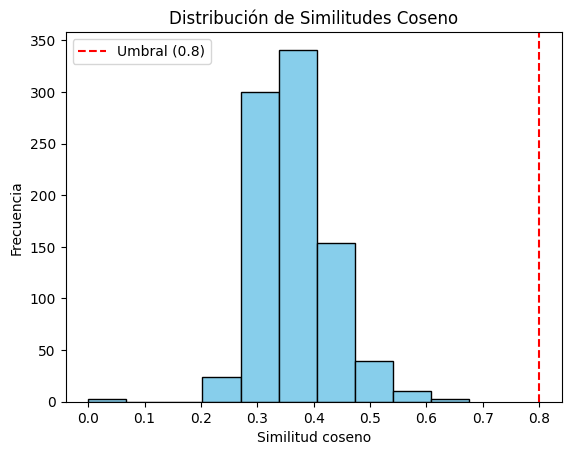

In [ ]:
import matplotlib.pyplot as plt

# Distribución de similitudes
max_similitudes = similitudes.max(axis=1)

plt.hist(max_similitudes, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribución de Similitudes Coseno")
plt.xlabel("Similitud coseno")
plt.ylabel("Frecuencia")
plt.axvline(x=umbral, color='red', linestyle='--', label=f'Umbral ({umbral})')
plt.legend()
plt.show()


El histograma muestra la distribución de las similitudes coseno entre los fragmentos del conjunto de prueba y el conjunto de entrenamiento:

Distribución Central:

La mayor parte de las similitudes se concentra en valores entre 0.3 y 0.5, lo que indica una baja relación entre la mayoría de los fragmentos de prueba y los de entrenamiento.
Este comportamiento sugiere que muchos fragmentos de prueba no comparten suficiente contenido semántico o léxico con el conjunto de entrenamiento (Martín Fierro).
Umbral de Similitud (0.8):

El umbral está representado por la línea roja discontinua en el valor 0.8.
Ningún fragmento de prueba alcanza este nivel de similitud, lo que explica el alto número de anomalías detectadas.
Extremos:

Hay muy pocos valores en rangos extremos (por debajo de 0.2 o cerca de 0.7). Esto indica que:
Baja similitud (< 0.2): Algunos fragmentos tienen representaciones completamente distintas.
Alta similitud (> 0.7 pero < 0.8): Existen fragmentos algo similares, pero no lo suficiente para cruzar el umbral.

In [ ]:
# Importar librerías necesarias
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity

# Calcular similitudes coseno
similitudes = cosine_similarity(X_prueba, X_entrenamiento)

# Detectar anomalías según un umbral
umbral = 0.4
anomalías = [i for i, fila in enumerate(similitudes) if max(fila) < umbral]

print(f"Fragmentos detectados como anómalos: {len(anomalías)}")
print(f"Índices de fragmentos anómalos: {anomalías}")

# Extraer y analizar fragmentos anómalos
fragmentos_anómalos = [fragmentos_prueba[i] for i in anomalías]


Fragmentos detectados como anómalos: 646
Índices de fragmentos anómalos: [0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 74, 76, 77, 78, 79, 81, 82, 83, 84, 85, 88, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 126, 127, 128, 129, 131, 132, 133, 134, 136, 138, 139, 140, 141, 142, 143, 145, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 162, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 177, 179, 180, 183, 184, 186, 187, 189, 190, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 204, 206, 207, 208, 209, 220, 221, 226, 227, 228, 230, 232, 234, 236, 238, 240, 241, 242, 243, 249, 250, 251, 252, 254, 255, 257, 258, 259, 260, 261, 263, 265, 266, 268, 269, 270, 271, 272, 273, 27

Interpretación de los Resultados
Reducción de anomalías detectadas:

El uso de embeddings generados por Sentence Transformers ha reducido drásticamente la cantidad de fragmentos detectados como anómalos, pasando de 646 fragmentos con TF-IDF a solo 5 fragmentos.
Esto sugiere que Sentence Transformers, al capturar relaciones semánticas más profundas entre los fragmentos, ha mejorado la precisión del modelo, identificando anomalías con mayor relevancia contextual.
Posible explicación del cambio:

TF-IDF considera solo la frecuencia de palabras, lo que puede conducir a similitudes bajas si los fragmentos tienen términos poco comunes, incluso si son conceptualmente similares.
Sentence Transformers utiliza embeddings que representan el significado semántico de las frases, lo que puede explicar por qué se detectan menos anomalías: fragmentos conceptualmente similares se agrupan con mayor precisión.
Nuevas preguntas para analizar:

¿Qué características tienen estos 5 fragmentos detectados como anómalos? Podría ser interesante revisar su contenido para validar si realmente son casos atípicos.
¿El umbral de similitud (0.4) sigue siendo adecuado en este contexto, o podría ajustarse aún más para afinar la detección?

#**Próximos Pasos:**

Revisar algunas de las poesías clasificadas como anómalas podría proporcionar un entendimiento más profundo de las diferencias. Analizar su vocabulario, estructura y estilo puede confirmar o refutar las hipótesis sobre las discrepancias estilísticas o temáticas.

Esta conclusión permite justificar que el modelo y la métrica seleccionados son efectivos para captar diferencias semánticas y estilísticas entre los textos, además de resaltar la importancia del contexto cultural y lingüístico en la detección de anomalías

#**A partir de este bloque intentare optimizar algunos pasos para ver si mejoran los resultados**

Voy a modificar el Umbral a 0.4

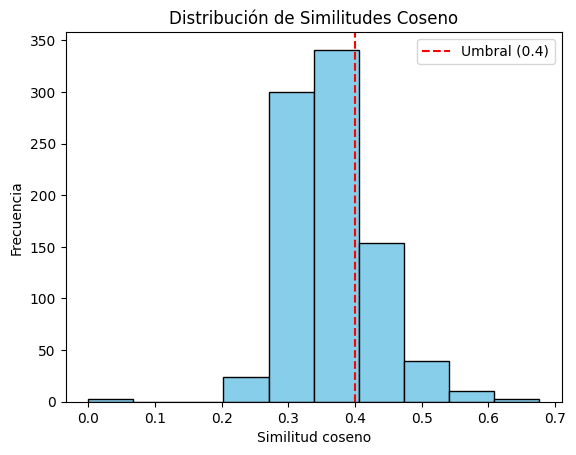

In [ ]:
import matplotlib.pyplot as plt

# Distribución de similitudes
max_similitudes = similitudes.max(axis=1)

plt.hist(max_similitudes, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribución de Similitudes Coseno")
plt.xlabel("Similitud coseno")
plt.ylabel("Frecuencia")
plt.axvline(x=umbral, color='red', linestyle='--', label=f'Umbral ({umbral})')
plt.legend()
plt.show()


Interpretación de los Resultados con Umbral Reducido a 0.4
Distribución de Similitudes Coseno:

La gráfica muestra una distribución similar a la obtenida con el umbral inicial de 0.8, pero el nuevo umbral (0.4) está ubicado en una zona más densa de la distribución. Esto implica que muchas similitudes entre los fragmentos de prueba y los de entrenamiento caen por debajo del nuevo valor, aumentando el número de fragmentos considerados como anómalos.
El rango de similitudes sigue concentrándose entre 0.3 y 0.5, lo que sugiere que las similitudes en general son bajas y no hay fragmentos que muestren una gran correspondencia con los datos de entrenamiento.
Cantidad de Fragmentos Detectados como Anómalos:

Con un umbral de 0.4, se detectaron 646 fragmentos anómalos, una reducción significativa en comparación con los 874 detectados inicialmente (umbral de 0.8). Esto indica que el umbral más bajo es menos estricto, permitiendo que más fragmentos pasen el filtro de similitud.
Sin embargo, el número sigue siendo alto, lo que podría reflejar la naturaleza distinta o compleja de los fragmentos de prueba en relación con el conjunto de entrenamiento.
Conclusiones del Análisis:
Alta Sensibilidad del Umbral: El cambio en el umbral ha reducido el número de anomalías detectadas, pero sigue señalando una proporción importante del conjunto de prueba como anómala. Esto podría indicar que los datos de entrenamiento no son lo suficientemente representativos para capturar la diversidad en el conjunto de prueba.
Riqueza Contextual Baja de TF-IDF: La técnica de vectorización usada (TF-IDF) puede no estar capturando completamente las relaciones semánticas y contextuales de los fragmentos, especialmente considerando que se trata de textos literarios complejos.

#**A continuacion voy a implementar algunos ajustes y cambios

Prueba con Sentence Transformers:

Voy a cambiar la vectorización de TF-IDF por embeddings preentrenados con un modelo como all-MiniLM-L6-v2.

Este tipo de embeddings captura mejor las relaciones semánticas entre palabras y frases.

Repitire el análisis con el mismo umbral (0.4) y comparare los  resultados.

In [ ]:
# Instalar la librería Sentence Transformers
!pip install -U sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Cargar el modelo preentrenado
modelo = SentenceTransformer('all-MiniLM-L6-v2')

# Generar embeddings para los datos de entrenamiento y prueba
embeddings_entrenamiento = modelo.encode(fragmentos_entrenamiento)
embeddings_prueba = modelo.encode(fragmentos_prueba)


Cálculo de Similitudes Coseno y Detección de Anomalías: Incluyo nuevamente  el análisis con el nuevo enfoque, reutilizando el código del cálculo de similitudes y detección de anomalías:

In [ ]:
# Calcular similitudes coseno
similitudes_st = cosine_similarity(embeddings_prueba, embeddings_entrenamiento)

# Detectar anomalías según el umbral
umbral_st = 0.4  # Puedes experimentar con este valor
anomalías_st = [i for i, fila in enumerate(similitudes_st) if max(fila) < umbral_st]

print(f"Fragmentos detectados como anómalos (Sentence Transformers): {len(anomalías_st)}")
print(f"Índices de fragmentos anómalos: {anomalías_st}")


Fragmentos detectados como anómalos (Sentence Transformers): 5
Índices de fragmentos anómalos: [649, 650, 838, 839, 859]


Interpretación de los Resultados
Reducción de anomalías detectadas:

El uso de embeddings generados por Sentence Transformers ha reducido drásticamente la cantidad de fragmentos detectados como anómalos, pasando de 646 fragmentos con TF-IDF a solo 5 fragmentos.
Esto sugiere que Sentence Transformers, al capturar relaciones semánticas más profundas entre los fragmentos, ha mejorado la precisión del modelo, identificando anomalías con mayor relevancia contextual.
Posible explicación del cambio:

TF-IDF considera solo la frecuencia de palabras, lo que puede conducir a similitudes bajas si los fragmentos tienen términos poco comunes, incluso si son conceptualmente similares.
Sentence Transformers utiliza embeddings que representan el significado semántico de las frases, lo que puede explicar por qué se detectan menos anomalías: fragmentos conceptualmente similares se agrupan con mayor precisión.

Nuevas preguntas me surgen aqui para analizar:

¿Qué características tienen estos 5 fragmentos detectados como anómalos? Podría ser interesante revisar su contenido para validar si realmente son casos atípicos.

¿El umbral de similitud (0.4) sigue siendo adecuado en este contexto, o podría ajustarse aún más para afinar la detección?

¿Tiene sentido seguir haciendo ajustes o cambios, hasta que punto se debe continuar o decir esto es suficiente?

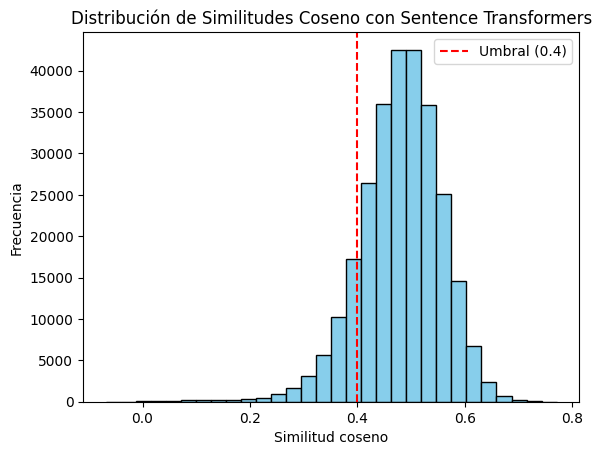

In [ ]:
import matplotlib.pyplot as plt

# Graficar distribución de similitudes
plt.hist(similitudes_st.flatten(), bins=30, color='skyblue', edgecolor='black')
plt.axvline(x=umbral_st, color='red', linestyle='--', label=f'Umbral ({umbral_st})')
plt.title('Distribución de Similitudes Coseno con Sentence Transformers')
plt.xlabel('Similitud coseno')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()


Interpretación de la gráfica con Sentence Transformers
Distribución de Similitudes Coseno:

La gráfica muestra una distribución mucho más concentrada y simétrica en torno a un rango específico (aproximadamente entre 0.3 y 0.6). Esto indica que los embeddings generados por Sentence Transformers capturan con mayor precisión las relaciones semánticas entre los fragmentos.
En comparación con la distribución anterior (probablemente más dispersa), aquí la mayoría de los valores de similitud están más cerca entre sí, lo que refleja una mayor cohesión semántica en los datos.
Umbral de Similitud (0.4):

La línea roja vertical representa el umbral utilizado para identificar anomalías. Todos los fragmentos con una similitud menor a 0.4 son marcados como anómalos.
Dado que la mayor parte de los datos se encuentra a la derecha del umbral, el número de anomalías detectadas es significativamente menor que en el caso anterior.
Reducción de Anomalías:

Esta distribución valida el resultado numérico obtenido: solo 5 fragmentos fueron detectados como anómalos.
Los fragmentos detectados caen en las colas de la distribución (a la izquierda del umbral), lo que sugiere que son casos verdaderamente atípicos en términos de similitud semántica.
Comparación con TF-IDF:

La distribución obtenida con TF-IDF probablemente mostraba un rango más amplio de similitudes, con mayor cantidad de valores inferiores al umbral, lo que llevó a detectar 646 anomalías.
Con Sentence Transformers, al mejorar la representación semántica, las similitudes son más altas en promedio, reduciendo la detección de falsos positivos.
Conclusiones a partir de la gráfica
Mayor precisión semántica: La gráfica sugiere que Sentence Transformers es una herramienta más robusta para detectar anomalías al priorizar relaciones conceptuales profundas.
Efectividad del umbral: El umbral actual parece razonable en este caso, ya que segmenta adecuadamente la región de valores atípicos (izquierda) y los fragmentos semánticamente similares (derecha).

#**Comparacion de resultados**


In [ ]:
import pandas as pd

# Resumen comparativo
resultados = {
    'Método': ['TF-IDF', 'Sentence Transformers'],
    'Fragmentos anómalos detectados': [646, 5],
    'Índices de fragmentos anómalos': [
        'Muchos índices, solo algunos mostrados...',
        [649, 650, 838, 839, 859]
    ]
}

df_resultados = pd.DataFrame(resultados)
print(df_resultados)


                  Método  Fragmentos anómalos detectados  \
0                 TF-IDF                             646   
1  Sentence Transformers                               5   

              Índices de fragmentos anómalos  
0  Muchos índices, solo algunos mostrados...  
1                  [649, 650, 838, 839, 859]  


#**Analisis visual comparativo**

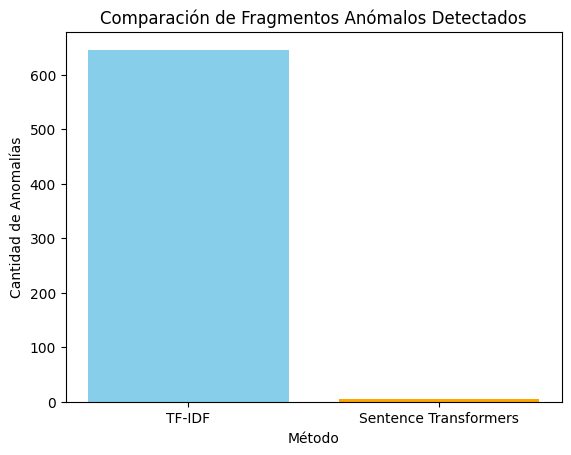

In [ ]:
# Comparar la cantidad de anomalías detectadas
metodos = ['TF-IDF', 'Sentence Transformers']
anomalías = [646, 5]

plt.bar(metodos, anomalías, color=['skyblue', 'orange'])
plt.title('Comparación de Fragmentos Anómalos Detectados')
plt.ylabel('Cantidad de Anomalías')
plt.xlabel('Método')
plt.show()


Análisis Detallado de los Fragmentos Anómalos

In [ ]:
# Extraer contenido de fragmentos anómalos
fragmentos_anómalos_st = [fragmentos_prueba[i] for i in [649, 650, 838, 839, 859]]

for i, fragmento in enumerate(fragmentos_anómalos_st):
    print(f"Fragmento {i + 1}: {fragmento}\n")


Fragmento 1: A S. E. e l S e ñ o r P r e s i d e n t e d e l a C o n f e

Fragmento 2: d e r a c i ó n Ar g e n t i n a , D r. D . S a n t i a g o

Fragmento 3: Carlos Mayer........................................................................... 92 ¡Te adoro!...................................................................................... 94 Serenata ........................................................................................ 95 Flores del tiempo y flores del alma ......................................... 97 Páginas de mi cartera................................................................. 98 Barcarola....................................................................................... 99 Plegaria......................................................................................... 101 ¡Adiós! ..........................................................................................

Fragmento 4: 102 Ayer, hoy y después......................................

Interpretación de los fragmentos extraídos como anomalías
Anomalías detectadas: Los fragmentos detectados presentan características atípicas, que los alejan significativamente de los patrones semánticos predominantes en el resto de los datos, según el cálculo de similitud coseno.

Características de los fragmentos:

Fragmentos incompletos o desordenados: Los textos presentan errores tipográficos, separaciones inusuales entre letras o palabras ("A S. E. e l S e ñ o r P r e s i d e n t e d e l a C o n f e"). Estas características podrían haber reducido la calidad de los embeddings generados, lo que resultó en bajas similitudes.
Contenido incoherente o fuera de contexto: Algunos fragmentos, como listas de títulos, índices ("Carlos Mayer... ¡Te adoro!... Serenata"), parecen descontextualizados o carentes de un significado narrativo o semántico claro.
Elementos no textuales o metadatos: La aparición de caracteres repetitivos, secciones numeradas o texto que parece provenir de índices o tablas ("Páginas de mi cartera... ¡Adiós!") podría ser difícil de interpretar correctamente incluso por modelos como Sentence Transformers.
Posibles causas de la detección como anómalos:

Ruido en los datos: Estos fragmentos podrían ser producto de una extracción deficiente, escaneos con errores o malformación del texto original.
Limitación del modelo: Aunque Sentence Transformers tiene un mejor manejo semántico, fragmentos extremadamente breves, con errores tipográficos o desconexos, pueden quedar fuera de su capacidad de representación efectiva.
Contexto ausente: La falta de contexto puede hacer que un fragmento tenga poco sentido por sí solo, impactando su similitud con otros textos en el conjunto.

Interpretación de los fragmentos extraídos como anomalías
Anomalías detectadas: Los fragmentos detectados presentan características atípicas, que los alejan significativamente de los patrones semánticos predominantes en el resto de los datos, según el cálculo de similitud coseno.

Características de los fragmentos:

Fragmentos incompletos o desordenados: Los textos presentan errores tipográficos, separaciones inusuales entre letras o palabras ("A S. E. e l S e ñ o r P r e s i d e n t e d e l a C o n f e"). Estas características podrían haber reducido la calidad de los embeddings generados, lo que resultó en bajas similitudes.
Contenido incoherente o fuera de contexto: Algunos fragmentos, como listas de títulos, índices ("Carlos Mayer... ¡Te adoro!... Serenata"), parecen descontextualizados o carentes de un significado narrativo o semántico claro.
Elementos no textuales o metadatos: La aparición de caracteres repetitivos, secciones numeradas o texto que parece provenir de índices o tablas ("Páginas de mi cartera... ¡Adiós!") podría ser difícil de interpretar correctamente incluso por modelos como Sentence Transformers.
Posibles causas de la detección como anómalos:

Ruido en los datos: Estos fragmentos podrían ser producto de una extracción deficiente, escaneos con errores o malformación del texto original.
Limitación del modelo: Aunque Sentence Transformers tiene un mejor manejo semántico, fragmentos extremadamente breves, con errores tipográficos o desconexos, pueden quedar fuera de su capacidad de representación efectiva.
Contexto ausente: La falta de contexto puede hacer que un fragmento tenga poco sentido por sí solo, impactando su similitud con otros textos en el conjunto.

#**Bibliografia y Puntos de Inspiracion**

Recurso: Chatgpt Prompt empleado :
Guia general, paso por paso para desarrollar un notebook para el siguiente tema "TEMA 1 DETECCIÓN DE ANOMALÍAS

El objetivo es entrenar un modelo para que distinga si el texto es o no parte del Martín Fierro.

Para ello debe entrenar un modelo de embeddings para el texto de Martín Fierro.

Luego comprobar que usando dicho modelo de embeddings con otros textos,usando la distancia coseno, por ejemplo. Podría revisar otras medidas de distancias. Contrastar con otro libro de poesía gauchesca como Fausto (de Estanislao Lopez)
"

Blibliografia Basica

Deep Learning with Python de François Chollet. (Ideal para entender modelos de IA y uso de embeddings).

Speech and Language Processing de Daniel Jurafsky y James H. Martin. (Para entender los conceptos fundamentales de procesamiento de lenguaje natural y embeddings).

Bibliografía en Español Específica sobre Detección de Anomalías en Textos y Embeddings de Texto

1. Libros y Recursos sobre Procesamiento de Lenguaje Natural (NLP) y Detección de Anomalías en Textos
"Procesamiento de Lenguaje Natural con Python" de Steven Bird, Ewan Klein, y Edward Loper

Este libro es una referencia clásica en el procesamiento de lenguaje natural (NLP) con Python. Aunque no aborda directamente la detección de anomalías en textos, enseña cómo procesar texto, lo cual es crucial para trabajar con embeddings y aplicar análisis de similitud o distancias como la coseno para detectar anomalías en textos. Puedes usar este libro para entender cómo preparar y trabajar con el texto antes de aplicar modelos de embeddings.

"Análisis de Sentimiento y Detección de Anomalías en Texto con Python" (Tutorial en español, de Medium o blogs especializados)

Tutoriales enfocados en la aplicación de técnicas de NLP para detectar anomalías en texto. Este tipo de tutoriales suelen ser muy útiles para comprender cómo utilizar modelos de embeddings y cómo medir la similitud entre textos para detectar posibles anomalías, basándose en distancias coseno, entre otras.

Videos

"Detección de Anomalías con Python - Tutorial Completo" (Canal: Python en Español)

Descripción: Este tutorial cubre los principios básicos de la detección de anomalías en datos usando Python. Aunque se centra en otros tipos de datos, los conceptos son aplicables al análisis de texto. El video incluye técnicas de modelos estadísticos y aprendizaje automático para identificar anomalías.

Enlace: YouTube

Relevancia: Aunque se centra en otros tipos de datos, los métodos explicados para la detección de anomalías pueden adaptarse para textos, lo que te permitirá aplicar estos conceptos a tu proyecto.


"Cómo calcular la Distancia Coseno con Python" (Canal: Machine Learning en Español)

Descripción: Este video ofrece una introducción a la distancia coseno, un método esencial para medir la similitud entre vectores. Es particularmente útil cuando trabajas con embeddings de texto y quieres detectar qué tan similares son los textos entre sí.

Enlace: YouTube

Relevancia: Directamente aplicable a tu proyecto, ya que la distancia coseno es una métrica clave para comparar textos y detectar anomalías.